In [10]:
mutable struct Value
    label::String
    data::Float64
    grad::Float64
    _prev::Set{Value}
    _op::String
    _backward::Function
end

In [11]:
import Base.:+, Base.:*, Base.:tanh

val(label::String, x::Float64) = Value(label, x, 0.0, Set(), "", () -> nothing)

function +(a::Value, b::Value)
    out = Value(
        "$(a.label) + $(b.label)",
        a.data + b.data,
        0.0,
        Set([a, b]),
        "+",
        identity
    )

    function _backward()
        a.grad = 1.0 * out.grad
        b.grad = 1.0 * out.grad
    end
    out._backward = _backward

    return out
end

function *(a::Value, b::Value)
    out = Value(
        "$(a.label) * $(b.label)",
        a.data * b.data,
        0.0,
        Set([a, b]),
        "*",
        identity
    )

    function _backward()
        a.grad = b.data * out.grad
        b.grad = a.data * out.grad
    end
    out._backward = _backward

    return out
end

function tanh(v::Value)
    out = Value(
        "tanh($(v.label))",
        tanh(v.data),
        0.0,
        Set([v]),
        "tanh",
        identity
    )

    function _backward()
        v.grad = (1.0 - tanh(v.data)^2) * out.grad
    end
    out._backward = _backward

    return out
end

tanh (generic function with 13 methods)

In [12]:
a = val("a", 2.0)
b = val("b", -3.0)
c = val("c", 10.0)
d = a*b + c

Value("a * b + c", 4.0, 0.0, Set(Value[Value("c", 10.0, 0.0, Set{Value}(), "", var"#11#12"()), Value("a * b", -6.0, 0.0, Set(Value[Value("a", 2.0, 0.0, Set{Value}(), "", var"#11#12"()), Value("b", -3.0, 0.0, Set{Value}(), "", var"#11#12"())]), "*", var"#_backward#14"{Value, Value, Value}(Value("a", 2.0, 0.0, Set{Value}(), "", var"#11#12"()), Value("b", -3.0, 0.0, Set{Value}(), "", var"#11#12"()), Value(#= circular reference @-2 =#)))]), "+", var"#_backward#13"{Value, Value, Value}(Value("a * b", -6.0, 0.0, Set(Value[Value("a", 2.0, 0.0, Set{Value}(), "", var"#11#12"()), Value("b", -3.0, 0.0, Set{Value}(), "", var"#11#12"())]), "*", var"#_backward#14"{Value, Value, Value}(Value("a", 2.0, 0.0, Set{Value}(), "", var"#11#12"()), Value("b", -3.0, 0.0, Set{Value}(), "", var"#11#12"()), Value(#= circular reference @-2 =#))), Value("c", 10.0, 0.0, Set{Value}(), "", var"#11#12"()), Value(#= circular reference @-2 =#)))

In [13]:
using GraphViz

function trace(root::Value)
    nodes, edges = Set(), Set()

    function build(v::Value)
        if v ∉ nodes
            push!(nodes, v)
            for child in v._prev
                push!(edges, (child, v))
                build(child)
            end
        end
    end
    build(root)

    return nodes, edges
end

function dot_str(v::Value)::String
    nodes, edges = trace(v)
    lines = String[]

    for node in nodes
        uid = string(hash(node))
        push!(lines, """"$(uid)" [label="data = $(node.data) | grad = $(node.grad)"; shape="record"]""")

        if node._op != ""
            push!(lines, """ "$(uid * node._op)" [label="$(node._op)"]""")
            push!(lines, """ "$(uid * node._op)" -> "$(uid)" """)
        end
    end
    for (a, b) in edges
        push!(lines, """ "$(string(hash(a)))" -> "$(string(hash(b)) * b._op)" """)
    end
    attrs = [
        "graph [rankdir=LR;]"
    ]
    return "digraph G {\n\t" * join(attrs, "\n\t") * "\n" * join(lines, "\n\t") * "\n}"
end

function visualize(v::Value)
    g = GraphViz.Graph(dot_str(v))
    GraphViz.layout!(g, engine="dot")
    return g
end


visualize (generic function with 1 method)

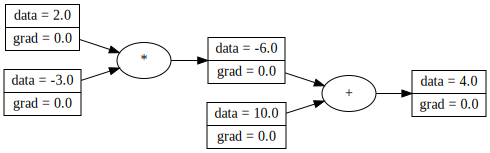

In [14]:
visualize(d)

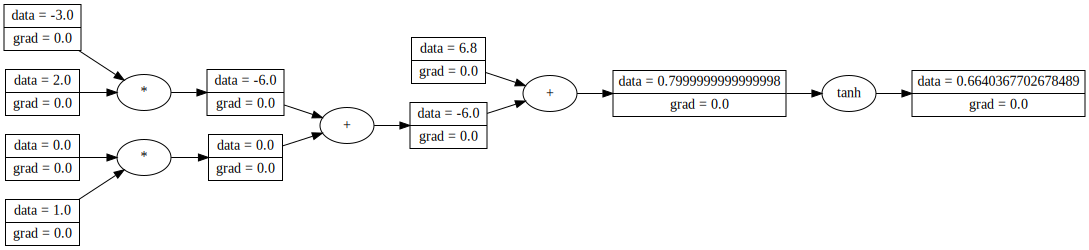

In [15]:
# A simple neuron (perceptron)
x1 = val("x1", 2.0)
x2 = val("x2", 0.0)

w1 = val("w1", -3.0)
w2 = val("w2", 1.0)

b = val("b", 6.8)

n = tanh(w1 * x1 + w2 * x2 + b)
visualize(n)

In [16]:
# Backward

# To do one step of the back-propagation, we have to set the grad of the output node to 
# 1.0 and call _backward() on it.

n.grad = 1.0
#n._backward()
#visualize(n)

1.0

In [17]:
function toposort(root::Value)
    visited = Set()
    order = Value[]

    function visit(v::Value)
        if v ∉ visited
            for child in v._prev
                visit(child)
            end
            push!(order, v)
            push!(visited, v)
        end
    end
    visit(root)

    return reverse(order)
end

toposort (generic function with 1 method)

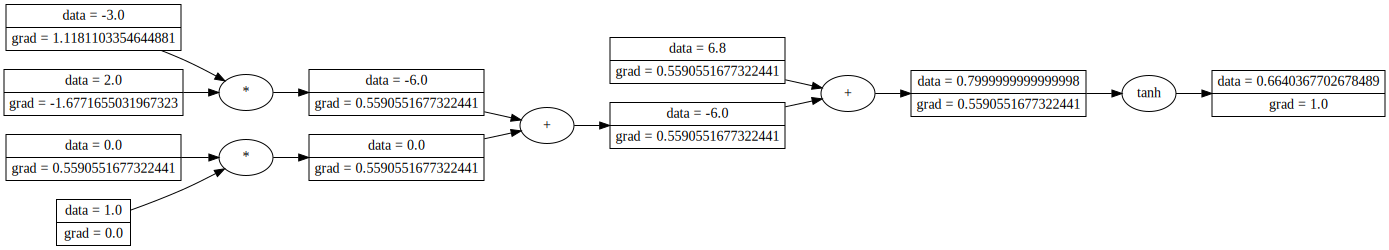

In [18]:
function backpropagate(root::Value)
    for node in toposort(root)
        node._backward()
    end
end

backpropagate(n)
visualize(n)